In [94]:
import numpy as np
import matplotlib.pyplot as plt

In [125]:
def generate_ratings(nb_rows, nb_cols, min_nb_recomm=1, max_nb_recomm=2, min_rating =1, max_rating=5, seed = 0):
  '''Function to generate test rating matrices 
  nb_rows : nb of users
  nb_cols : nb of items
  min_nb_recomm : minimum number of recommendation for each user
  max_nb_recomm : max number of recommendation for each user
  min_rating : minimum rating possible 
  max_rating : maximum rating possible
  seed : np random seed for reproducibility '''
  np.random.seed(seed)
  ratings = np.zeros((nb_rows,nb_cols))

  for i in range(nb_rows):

    nb_recomm = np.random.randint(min_nb_recomm, max_nb_recomm+1)

    indexes = np.random.choice(np.arange(nb_cols), nb_recomm, replace = False)

    for index in indexes :
      ratings[i,index] = np.random.randint(min_rating, max_rating)
  return ratings.astype(int)

ratings = generate_ratings(500,1000,2,5)

In [126]:
class recommender_system:
  '''Simple recommender system class based on matrix factorization'''

  def __init__(self, k, lr, lambda_reg):
    '''Instantiates recommendation_system class.
    k : rank dimension of factorized matrix
    lr : learning rate
    lambda_reg : regularization parameter
    max_value : maximum value possible for the generated matrices to avoid overflow'''
    self.k = k
    self.lr = lr
    self.lambda_reg = lambda_reg
    return None

  def instantiate_matrices(self):
    '''Instantiate factorized matrixes'''
    self.first_mat = np.random.randn(self.nb_rows, self.k)
    self.second_mat = np.random.randn(self.nb_cols, self.k)

  def instantiate_initially_pressent_items(self):
    '''Creates a 2d list from Ratings. Each row i of this list contains the items that the user i has already rated'''
    self.tested_items = [[] for i in range(self.nb_rows)]
    for row, col, _ in self.Ratings:
      self.tested_items[row].append(col)

  def load_sparse_data(self,file_, delimiter = ",", nb_rows_to_keep = -1, nb_cols_to_keep =-1, shuffle_matrix = True):
    '''Load data and shape it correctly for recommendation. Output format is a 2d numpy array. Each element of this output
      is in the format [row of the rating, column of the rating, Rating]
    file : either path to txt or csv file containing the dataset, or matrix to be used for recommendation. If file is a path
    shuffle_matrix : Boolean. if set to True
    nb_rows_to_keep : Number of rows to keep (if negative, keep all rows)
    nb_cols_to_keep : Number of columns to keep (if negative, keep all rows)'''

    if isinstance(file_,str):
      grade_matrix = np.genfromtxt(file_, delimiter, dtype = "int32")

    else:
      grade_matrix = file_

    self.nb_rows = len(grade_matrix)
    self.nb_cols = len(grade_matrix[0])

    if nb_rows_to_keep >0 and nb_rows_to_keep < len(grade_matrix):
      grade_matrix = grade_matrix[:nb_rows_to_keep]
      self.nb_rows = len(grade_matrix)

    if nb_cols_to_keep >0 and nb_cols_to_keep < len(grade_matrix[0]):
      grade_matrix = grade_matrix[:,:nb_cols_to_keep]
      self.nb_cols = len(grade_matrix[0])

    self.instantiate_matrices()

    non_zero_indexes = np.nonzero(grade_matrix)

    n = len(non_zero_indexes[0])
    put_in_shape_matrix = np.array([[non_zero_indexes[0][i], non_zero_indexes[1][i], grade_matrix[non_zero_indexes[0][i], non_zero_indexes[1][i]]] for i in range(n)])
    put_in_shape_matrix = put_in_shape_matrix.astype(int)

    if shuffle_matrix:
      np.random.shuffle(put_in_shape_matrix)

    self.Ratings = put_in_shape_matrix

    self.instantiate_initially_pressent_items()
    return None


  def root_mean_square_error(self, first_mat, second_mat):
    '''Compute avera root mean square error'''
    error = 0
    Ratings = self.Ratings
    for row,col,rating in Ratings:
      predicted_ratings = first_mat[row].dot(second_mat[col].T)
      error += (rating-predicted_ratings)**2

    error = error / len(Ratings)
    return np.sqrt(error)

  def sgd_gradient_step(self):
    '''Stochastic gradient descent of factorized matrixes over a batch of indexex
    batch_indexes : array containing [row,col,rating] elements
    '''
    for row,col,rating in self.Ratings:

      predicted_rating = self.first_mat[row].dot(self.second_mat[col].T)
      error = rating - predicted_rating

      self.first_mat += self.lr*(error*self.second_mat[col] - self.lambda_reg*self.first_mat[row])
      self.second_mat += self.lr*(error*self.first_mat[row] - self.lambda_reg*self.second_mat[col])

  def matrix_factorization(self, number_iterations):
    losses = []
    for i in range(number_iterations):
      self.sgd_gradient_step()
      loss = self.root_mean_square_error(self.first_mat, self.second_mat)
      losses.append(loss)
      print("RMSE after epoch is :",loss)
    return losses

  def get_recommendation(self, user_id, nb_recom = 2):
    curr_ratings = np.array(np.matmul(self.first_mat, self.second_mat.T)[user_id])

    ordered_item_indexes = np.argsort(curr_ratings)
    ordered_item_indexes = [index for index in ordered_item_indexes if index not in self.tested_items[user_id]]
    nb_recom = nb_recom if nb_recom< len(ordered_item_indexes) else len(ordered_item_indexes)
    recommendations = ordered_item_indexes[-nb_recom:]

    return recommendations
    
    

In [133]:
rec_sys = recommender_system(70, 0.0001, 1)
rec_sys.load_sparse_data(ratings)

In [134]:
n_epochs = 50
losses = rec_sys.matrix_factorization(n_epochs)

RMSE after epoch is : 8.653861783601444
RMSE after epoch is : 8.53510495818391
RMSE after epoch is : 8.430050131593788
RMSE after epoch is : 8.346910740133831
RMSE after epoch is : 8.29024471262152
RMSE after epoch is : 8.25507661597453
RMSE after epoch is : 8.233830198231233
RMSE after epoch is : 8.220821267740677
RMSE after epoch is : 8.212626221804426
RMSE after epoch is : 8.20730244081037
RMSE after epoch is : 8.203744310456674
RMSE after epoch is : 8.201306620415291
RMSE after epoch is : 8.199600760927165
RMSE after epoch is : 8.19838508761577
RMSE after epoch is : 8.197504873763702
RMSE after epoch is : 8.196858485502196
RMSE after epoch is : 8.196377700742865
RMSE after epoch is : 8.196015876062292
RMSE after epoch is : 8.195740612981828
RMSE after epoch is : 8.195529091161252
RMSE after epoch is : 8.19536503201143
RMSE after epoch is : 8.195236686301664
RMSE after epoch is : 8.19513547958447
RMSE after epoch is : 8.195055088151715
RMSE after epoch is : 8.194990801156651
RMSE af

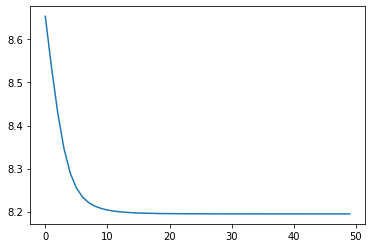

In [135]:
plt.plot(range(n_epochs),losses)
plt.show()

In [136]:
rec_sys.get_recommendation(2)

[728, 318]